## I will use this to predict the winner of the next F1 race using AI (ML)

### https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020/data


In [1]:
import pandas as pd
import glob
import sqlite3
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
# read all csv files in /data folder using glob and each file should be added to a sqlite database as a table

csv_files = glob.glob('data/*.csv')

conn = sqlite3.connect('data.db')


for file in csv_files:
    df = pd.read_csv(file)

    table_name = file.split('/')[-1].split('.')[0]
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    conn.commit()

#conn.close()
cursor = conn.cursor()

#cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")  
#print(cursor.fetchall())  



In [3]:
# drivers in 2024
q = """
select DISTINCT drivers.driverId, drivers.code, drivers.forename, drivers.surname from results
LEFT JOIN drivers where results.driverId = drivers.driverId
and raceId in (select raceId from races where year = 2024)
"""
cursor.execute(q)
rows = cursor.fetchall()
columns = [column[0] for column in cursor.description]
df = pd.DataFrame(rows, columns=columns)
df


df.driverId.values

array([830, 815, 832, 844, 847, 846,   1, 857,   4, 840, 855, 825, 817,
       852, 848, 807, 839, 842, 822, 858, 860])

In [4]:
# life time performance of drivers in 2024
q = f"""
select sum(results.points) as career_points, results.driverId from results
WHERE driverId in ({','.join([str(i) for i in df.driverId])})
GROUP BY driverId  
"""
rows = cursor.execute(q).fetchall()
columns = [column[0] for column in cursor.description]
df = df.merge(pd.DataFrame(rows, columns=columns), on='driverId')
df


,driverId,code,forename,surname,career_points
0,830,VER,Max,Verstappen,2744.5
1,815,PER,Sergio,Pérez,1552.0
2,832,SAI,Carlos,Sainz,1075.5
3,844,LEC,Charles,Leclerc,1172.0
4,847,RUS,George,Russell,543.0
5,846,NOR,Lando,Norris,768.0
6,1,HAM,Lewis,Hamilton,4713.5
7,857,PIA,Oscar,Piastri,194.0
8,4,ALO,Fernando,Alonso,2304.0
9,840,STR,Lance,Stroll,285.0


In [5]:
# performance in 2024
q = f"""
select sum(results.points) as points_2024, results.driverId from results
WHERE driverId in ({','.join([str(i) for i in df.driverId])}) and raceId in (select raceid from races where year = 2024)
GROUP BY driverId  
"""
rows = cursor.execute(q).fetchall()
columns = [column[0] for column in cursor.description]
df = df.merge(pd.DataFrame(rows, columns=columns), on='driverId')
df

,driverId,code,forename,surname,career_points,points_2024
0,830,VER,Max,Verstappen,2744.5,231.0
1,815,PER,Sergio,Pérez,1552.0,105.0
2,832,SAI,Carlos,Sainz,1075.5,134.0
3,844,LEC,Charles,Leclerc,1172.0,136.0
4,847,RUS,George,Russell,543.0,105.0
5,846,NOR,Lando,Norris,768.0,162.0
6,1,HAM,Lewis,Hamilton,4713.5,100.0
7,857,PIA,Oscar,Piastri,194.0,112.0
8,4,ALO,Fernando,Alonso,2304.0,45.0
9,840,STR,Lance,Stroll,285.0,23.0


In [6]:
# number of races
q = f"""
select count(results.points) as career_races, results.driverId from results
WHERE driverId in ({','.join([str(i) for i in df.driverId])}) 
GROUP BY driverId  
"""
rows = cursor.execute(q).fetchall()
columns = [column[0] for column in cursor.description]
df = df.merge(pd.DataFrame(rows, columns=columns), on='driverId')
df

,driverId,code,forename,surname,career_points,points_2024,career_races
0,830,VER,Max,Verstappen,2744.5,231.0,197
1,815,PER,Sergio,Pérez,1552.0,105.0,271
2,832,SAI,Carlos,Sainz,1075.5,134.0,196
3,844,LEC,Charles,Leclerc,1172.0,136.0,137
4,847,RUS,George,Russell,543.0,105.0,116
5,846,NOR,Lando,Norris,768.0,162.0,116
6,1,HAM,Lewis,Hamilton,4713.5,100.0,344
7,857,PIA,Oscar,Piastri,194.0,112.0,34
8,4,ALO,Fernando,Alonso,2304.0,45.0,392
9,840,STR,Lance,Stroll,285.0,23.0,156


In [7]:
q = f"""
select count(results.points) as career_wins, results.driverId from results
WHERE driverId in ({','.join([str(i) for i in df.driverId])}) and position = 1
GROUP BY driverId  
"""
rows = cursor.execute(q).fetchall()
columns = [column[0] for column in cursor.description]
df = df.merge(pd.DataFrame(rows, columns=columns), on='driverId', how = 'left')
df['career_wins'] = df['career_wins'].fillna(0)
df

,driverId,code,forename,surname,career_points,points_2024,career_races,career_wins
0,830,VER,Max,Verstappen,2744.5,231.0,197,61.0
1,815,PER,Sergio,Pérez,1552.0,105.0,271,6.0
2,832,SAI,Carlos,Sainz,1075.5,134.0,196,3.0
3,844,LEC,Charles,Leclerc,1172.0,136.0,137,6.0
4,847,RUS,George,Russell,543.0,105.0,116,2.0
5,846,NOR,Lando,Norris,768.0,162.0,116,1.0
6,1,HAM,Lewis,Hamilton,4713.5,100.0,344,104.0
7,857,PIA,Oscar,Piastri,194.0,112.0,34,0.0
8,4,ALO,Fernando,Alonso,2304.0,45.0,392,32.0
9,840,STR,Lance,Stroll,285.0,23.0,156,0.0


In [8]:
# performance in 2024
q = f"""
select sum(results.points) as points_2023, results.driverId from results
WHERE driverId in ({','.join([str(i) for i in df.driverId])}) and raceId in (select raceid from races where year = 2023)
GROUP BY driverId  
"""
rows = cursor.execute(q).fetchall()
columns = [column[0] for column in cursor.description]
df = df.merge(pd.DataFrame(rows, columns=columns), on='driverId',how = 'left')
df['points_2023'] = df['points_2023'].fillna(0)
df

,driverId,code,forename,surname,career_points,points_2024,career_races,career_wins,points_2023
0,830,VER,Max,Verstappen,2744.5,231.0,197,61.0,530.0
1,815,PER,Sergio,Pérez,1552.0,105.0,271,6.0,260.0
2,832,SAI,Carlos,Sainz,1075.5,134.0,196,3.0,178.0
3,844,LEC,Charles,Leclerc,1172.0,136.0,137,6.0,185.0
4,847,RUS,George,Russell,543.0,105.0,116,2.0,157.0
5,846,NOR,Lando,Norris,768.0,162.0,116,1.0,184.0
6,1,HAM,Lewis,Hamilton,4713.5,100.0,344,104.0,217.0
7,857,PIA,Oscar,Piastri,194.0,112.0,34,0.0,82.0
8,4,ALO,Fernando,Alonso,2304.0,45.0,392,32.0,198.0
9,840,STR,Lance,Stroll,285.0,23.0,156,0.0,68.0


In [9]:
q = """ 
select DISTINCT drivers.driverId, drivers.code, drivers.forename, drivers.surname, results.PositionOrder as position, races.circuitId, races.year, races.raceid, qualifying.position as qposition from results
INNER JOIN drivers on results.driverId = drivers.driverId
INNER JOIN races on results.raceId = races.raceId
INNER JOIN qualifying on results.raceId = qualifying.raceId and results.driverId = qualifying.driverId
--and drivers.driverId in (830, 815, 832, 844, 847, 846,   1, 857,   4, 840, 855, 825, 817,852, 848, 807, 839, 842, 822, 858)
"""
cursor.execute(q)
rows = cursor.fetchall()
columns = [column[0] for column in cursor.description]
df_new = pd.DataFrame(rows, columns=columns)

# replace all the /N in the position column with 20
#df_new['position'] = df_new['position'].replace(r'\N', 20)

df_new


,driverId,code,forename,surname,position,circuitId,year,raceId,qposition
0,1,HAM,Lewis,Hamilton,1,1,2008,18,1
1,2,HEI,Nick,Heidfeld,2,1,2008,18,5
2,3,ROS,Nico,Rosberg,3,1,2008,18,7
3,4,ALO,Fernando,Alonso,4,1,2008,18,12
4,5,KOV,Heikki,Kovalainen,5,1,2008,18,3
...,...,...,...,...,...,...,...,...,...
10249,839,OCO,Esteban,Ocon,16,9,2024,1132,18
10250,815,PER,Sergio,Pérez,17,9,2024,1132,19
10251,855,ZHO,Guanyu,Zhou,18,9,2024,1132,14
10252,847,RUS,George,Russell,19,9,2024,1132,1


In [10]:
X = df_new[['driverId','circuitId','year','raceId']]
df_new['position'] = df_new['position'].astype(int)
y = df_new['position']

race_id = 1128
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
X_test = X[X['raceId'] == race_id]
y_test = y[X['raceId'] == race_id]
X_train = X[X['raceId'] < race_id]
y_train = y[X['raceId'] < race_id]
#X_train = X[(X['year'].isin([2022, 2023, 2024])) & ~((X['year'] == 2024) & (X['circuitId'] == 9))]
#y_train = y[(X['year'].isin([2022, 2023, 2024])) & ~((X['year'] == 2024) & (X['circuitId'] == 9))]
#X_train = X[~((X['year'] == 2024) & (X['circuitId'] == 9))]
#y_train = y[~((X['year'] == 2024) & (X['circuitId'] == 9))]
#y_test = y[(X['year'] == 2024) & (X['circuitId'] == 9)]
#print(X_test)
from sklearn.ensemble import RandomForestClassifier


#print(df_new.dtypes)
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
#clf.score(X_test, y_test)

driver_test = df_new['code'][(df_new['year'] == 2024) & (df_new['circuitId'] == 9)]

for driver, actual, predicted in zip(driver_test, y_test, y_pred):
    print(f"Driver: {driver}, Actual: {actual}, Predicted: {predicted:.2f}")


mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# Calculate R-squared score
r_squared = clf.score(X_test, y_test)
print(f"R-squared: {r_squared:.2f}")

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Driver: HAM, Actual: 1, Predicted: 3.00
Driver: VER, Actual: 2, Predicted: 4.00
Driver: NOR, Actual: 3, Predicted: 5.00
Driver: PIA, Actual: 4, Predicted: 3.00
Driver: SAI, Actual: 5, Predicted: 5.00
Driver: HUL, Actual: 6, Predicted: 1.00
Driver: STR, Actual: 7, Predicted: 6.00
Driver: ALO, Actual: 8, Predicted: 19.00
Driver: ALB, Actual: 9, Predicted: 11.00
Driver: TSU, Actual: 10, Predicted: 16.00
Driver: SAR, Actual: 11, Predicted: 9.00
Driver: MAG, Actual: 12, Predicted: 13.00
Driver: RIC, Actual: 13, Predicted: 18.00
Driver: LEC, Actual: 14, Predicted: 9.00
Driver: BOT, Actual: 15, Predicted: 17.00
Driver: OCO, Actual: 16, Predicted: 15.00
Driver: PER, Actual: 17, Predicted: 14.00
Driver: ZHO, Actual: 18, Predicted: 2.00
Driver: RUS, Actual: 19, Predicted: 11.00
Driver: GAS, Actual: 20, Predicted: 12.00
Mean Squared Error: 32.65
R-squared: 0.05
Accuracy: 0.05


In [11]:

mse = mean_squared_error([10]*20, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 31.65


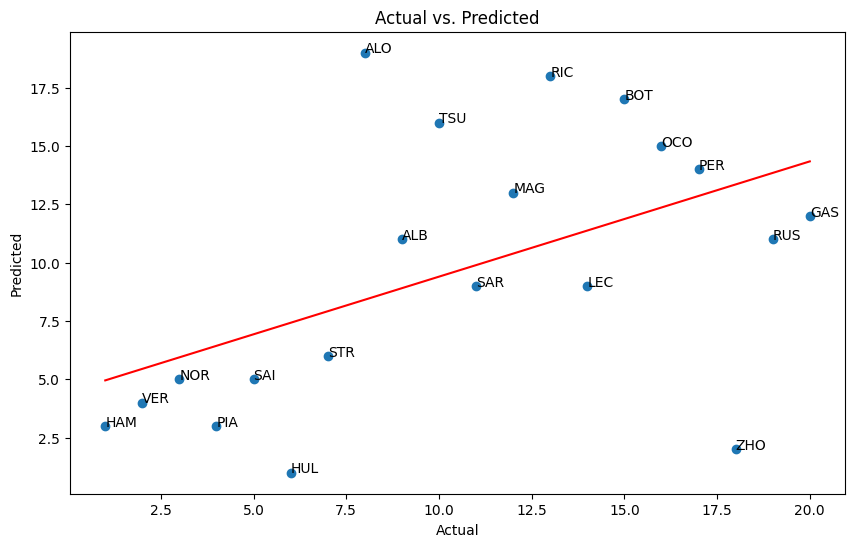

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Fit a line to the data
m, b = np.polyfit(y_test, y_pred, 1)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)

# Add labels
for i, driver in enumerate(driver_test):
    plt.text(y_test.values[i], y_pred[i], driver)

plt.plot(y_test, m*y_test + b, color='red')  # Add the line of best fit
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()


In [13]:
def make_predictions_unique(predictions, min_val=1, max_val=20):
    # Round predictions to nearest integer
    predictions = np.round(predictions).astype(int)
    
    # Clip predictions to ensure they are within the specified range
    predictions = np.clip(predictions, min_val, max_val)
    
    # Identify duplicate predictions
    unique_predictions = []
    available_values = set(range(min_val, max_val + 1))
    
    for pred in predictions:
        if pred in unique_predictions:
            # Assign the closest available unique value
            closest_value = min(available_values, key=lambda x: abs(x - pred))
            unique_predictions.append(closest_value)
            available_values.remove(closest_value)
        else:
            unique_predictions.append(pred)
            available_values.discard(pred)
    
    return np.array(unique_predictions)

     Driver  Actual  Predicted
9577    ALO       3          1
9576    PER       2          2
9575    VER       1          3
9578    SAI       4          4
9579    HAM       5          5
9580    STR       6          6
9581    RUS       7          7
9592    OCO      18          8
9589    HUL      15          9
9593    LEC      19         10
9594    PIA      20         11
9591    NOR      17         12
9588    DEV      14         13
9586    SAR      12         14
9584    ALB      10         15
9583    GAS       9         16
9585    TSU      11         17
9587    MAG      13         18
9590    ZHO      16         19
9582    BOT       8         20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


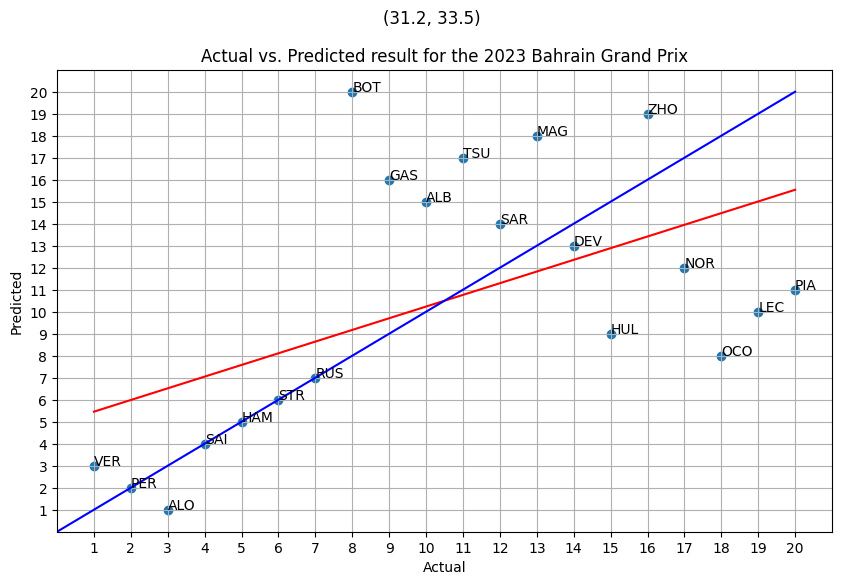

Accuracy: 0.25
     Driver  Actual  Predicted
9597    ALO       3          1
9595    PER       1          2
9598    RUS       4          3
9599    HAM       5          4
9600    SAI       6          5
9601    LEC       7          6
9602    OCO       8          7
9603    GAS       9          8
9606    HUL      12          9
9607    ZHO      13         10
9609    PIA      15         11
9614    STR      20         12
9613    ALB      19         13
9612    BOT      18         14
9611    NOR      17         15
9608    DEV      14         16
9604    MAG      10         17
9596    VER       2         18
9605    TSU      11         19
9610    SAR      16         20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


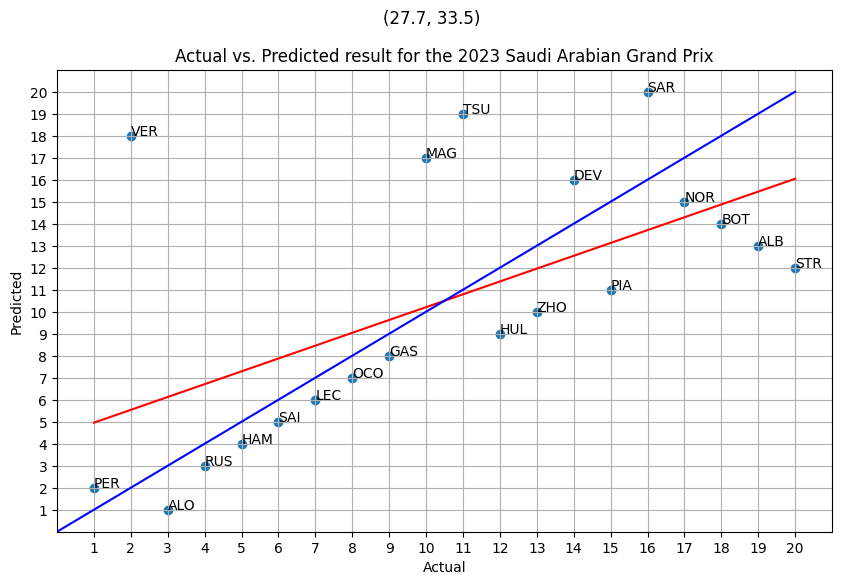

Accuracy: 0.00
     Driver  Actual  Predicted
9616    HAM       2          1
9617    ALO       3          2
9615    VER       1          3
9632    RUS      18          4
9626    SAI      12          5
9618    STR       4          6
9627    GAS      13          7
9621    HUL       7          8
9633    ALB      19          9
9634    LEC      20         10
9631    MAG      17         11
9630    SAR      16         12
9624    TSU      10         13
9620    NOR       6         14
9622    PIA       8         15
9619    PER       5         16
9623    ZHO       9         17
9625    BOT      11         18
9629    DEV      15         19
9628    OCO      14         20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


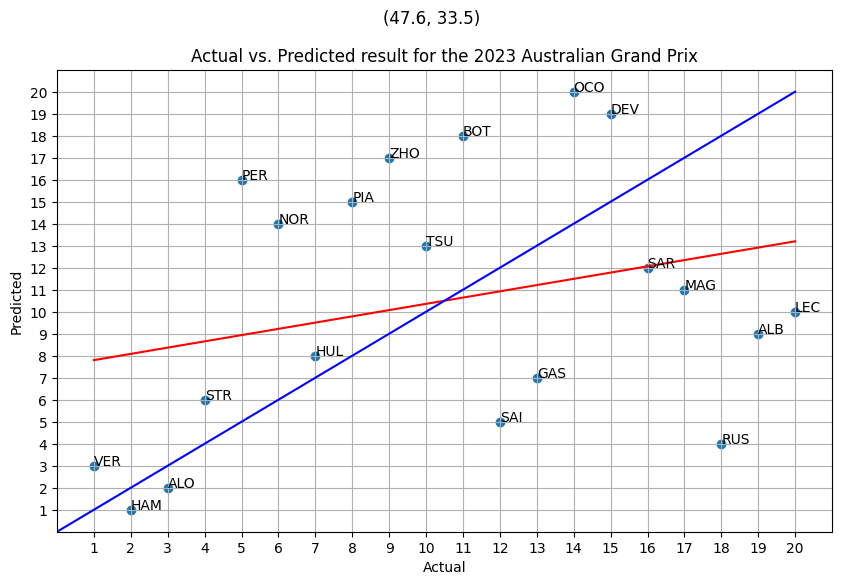

Accuracy: 0.00
     Driver  Actual  Predicted
9635    PER       1          1
9636    VER       2          2
9637    LEC       3          3
9638    ALO       4          4
9639    SAI       5          5
9640    HAM       6          6
9641    STR       7          7
9642    RUS       8          8
9643    NOR       9          9
9644    TSU      10         10
9645    PIA      11         11
9646    ALB      12         12
9649    OCO      15         13
9654    DEV      20         14
9653    ZHO      19         15
9648    GAS      14         16
9647    MAG      13         17
9650    SAR      16         18
9651    HUL      17         19
9652    BOT      18         20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


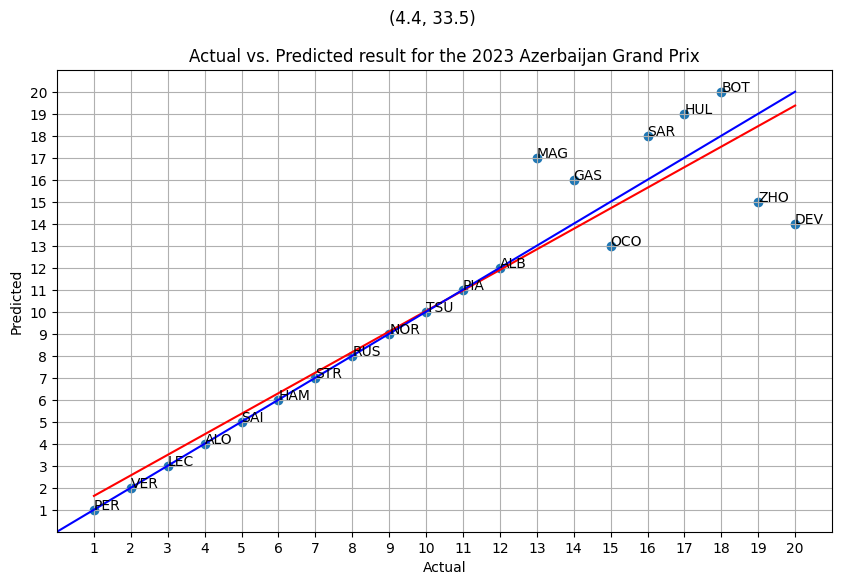

Accuracy: 0.60
     Driver  Actual  Predicted
9656    PER       2          1
9657    ALO       3          2
9655    VER       1          3
9658    RUS       4          4
9659    SAI       5          5
9660    HAM       6          6
9661    LEC       7          7
9662    GAS       8          8
9663    OCO       9          9
9664    MAG      10         10
9667    BOT      13         11
9668    ALB      14         12
9669    HUL      15         13
9666    STR      12         14
9665    TSU      11         15
9671    NOR      17         16
9672    DEV      18         17
9673    PIA      19         18
9670    ZHO      16         19
9674    SAR      20         20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


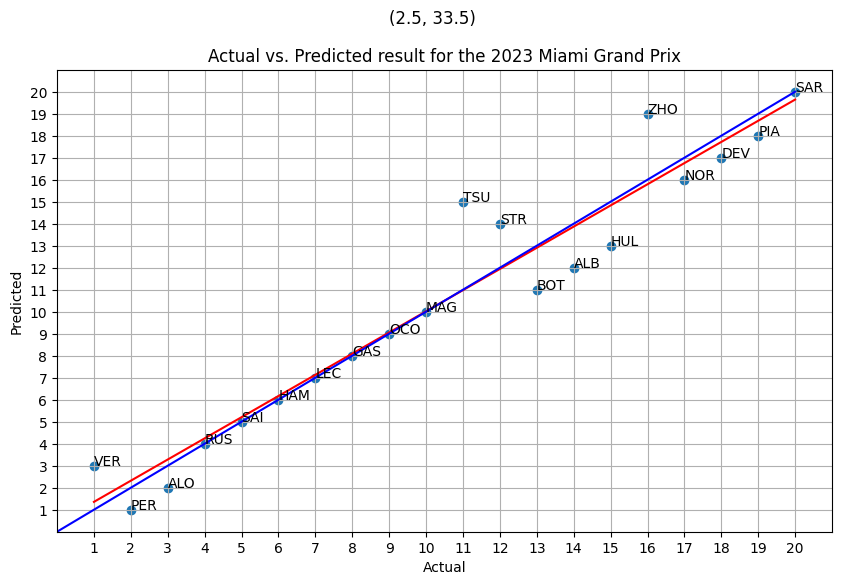

Accuracy: 0.40
     Driver  Actual  Predicted
9676    ALO       2          1
9677    OCO       3          2
9675    VER       1          3
9678    HAM       4          4
9680    LEC       6          5
9681    GAS       7          6
9682    SAI       8          7
9679    RUS       5          8
9683    NOR       9          9
9689    TSU      15         10
9694    STR      20         11
9693    MAG      19         12
9688    ALB      14         13
9686    DEV      12         14
9687    ZHO      13         15
9685    BOT      11         16
9690    PER      16         17
9691    HUL      17         18
9692    SAR      18         19
9684    PIA      10         20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


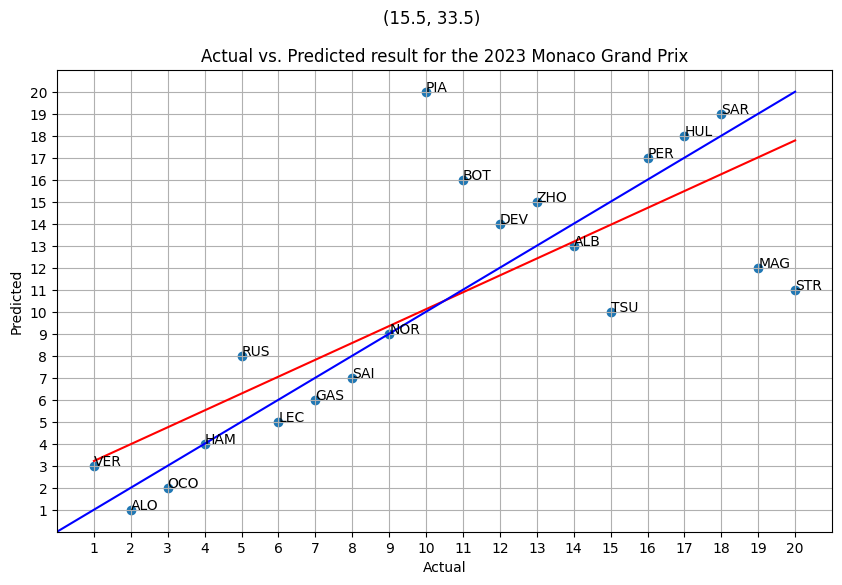

Accuracy: 0.10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


     Driver  Actual  Predicted
9696    HAM       2          1
9699    SAI       5          2
9695    VER       1          3
9701    ALO       7          4
9702    OCO       8          5
9700    STR       6          6
9704    GAS      10          7
9707    PIA      13          8
9709    HUL      15          9
9711    NOR      17         10
9714    SAR      20         11
9713    BOT      19         12
9710    ALB      16         13
9697    RUS       3         14
9705    LEC      11         15
9703    ZHO       9         16
9706    TSU      12         17
9708    DEV      14         18
9712    MAG      18         19
9698    PER       4         20


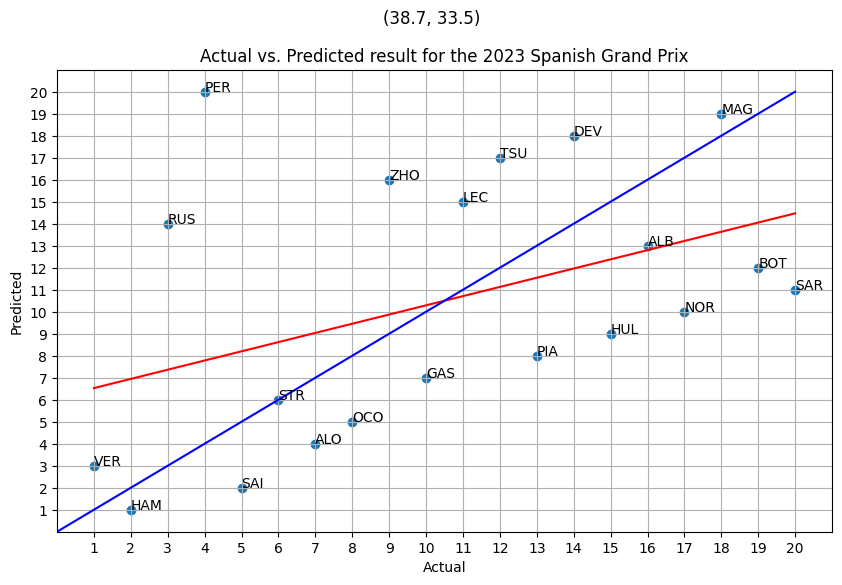

Accuracy: 0.05
     Driver  Actual  Predicted
9716    ALO       2          1
9717    HAM       3          2
9715    VER       1          3
9727    NOR      13          4
9722    OCO       8          5
9719    SAI       5          6
9725    PIA      11          7
9721    ALB       7          8
9729    HUL      15          9
9733    RUS      19         10
9723    STR       9         11
9720    PER       6         12
9732    DEV      18         13
9730    ZHO      16         14
9726    GAS      12         15
9724    BOT      10         16
9728    TSU      14         17
9731    MAG      17         18
9734    SAR      20         19
9718    LEC       4         20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


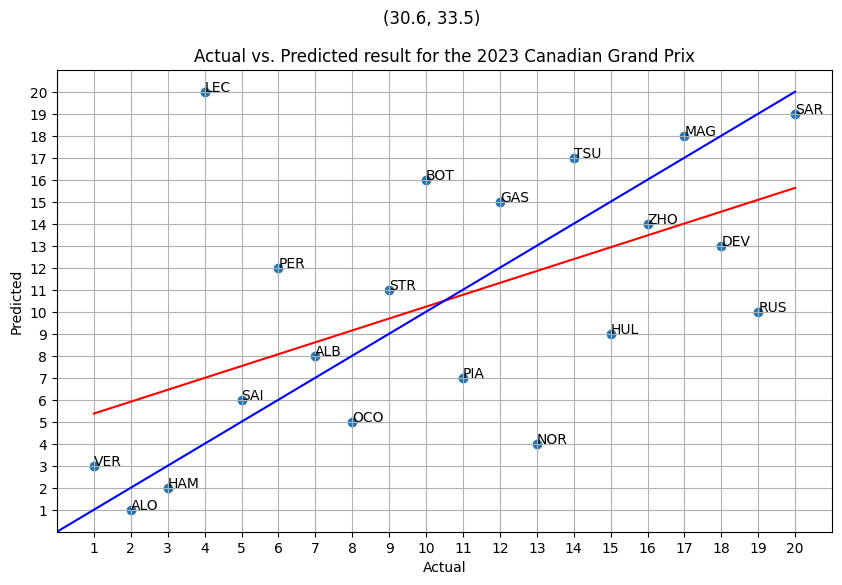

Accuracy: 0.00


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


     Driver  Actual  Predicted
9735    VER       1          1
9736    LEC       2          2
9738    NOR       4          3
9739    ALO       5          4
9740    SAI       6          5
9742    HAM       8          6
9741    RUS       7          7
9743    STR       9          8
9744    GAS      10          9
9745    ALB      11         10
9754    HUL      20         11
9752    MAG      18         12
9751    DEV      17         13
9749    BOT      15         14
9746    ZHO      12         15
9737    PER       3         16
9747    SAR      13         17
9750    PIA      16         18
9748    OCO      14         19
9753    TSU      19         20


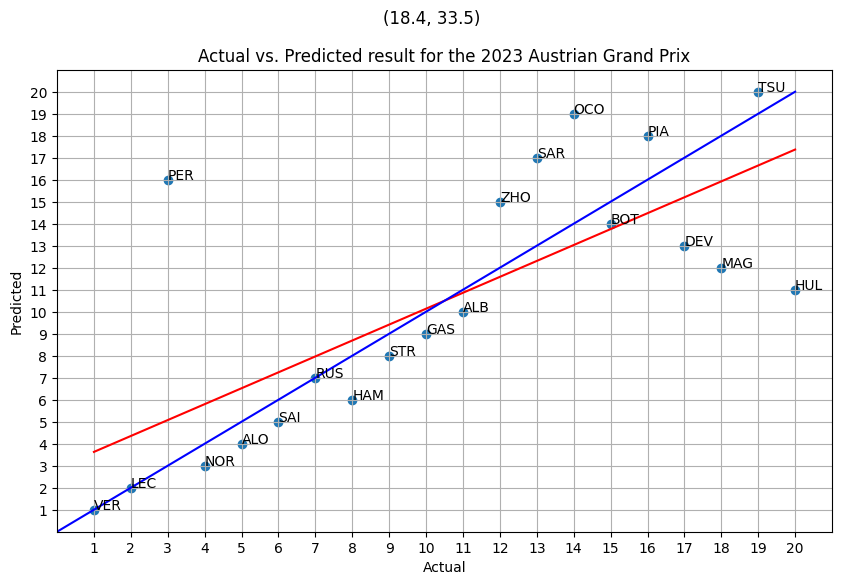

Accuracy: 0.15


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


     Driver  Actual  Predicted
9757    HAM       3          1
9755    VER       1          2
9756    NOR       2          3
9761    ALO       7          4
9759    RUS       5          5
9758    PIA       4          6
9762    ALB       8          7
9763    LEC       9          8
9764    SAI      10          9
9767    HUL      13         10
9772    GAS      18         11
9773    MAG      19         12
9768    STR      14         13
9765    SAR      11         14
9766    BOT      12         15
9760    PER       6         16
9769    ZHO      15         17
9770    TSU      16         18
9771    DEV      17         19
9774    OCO      20         20


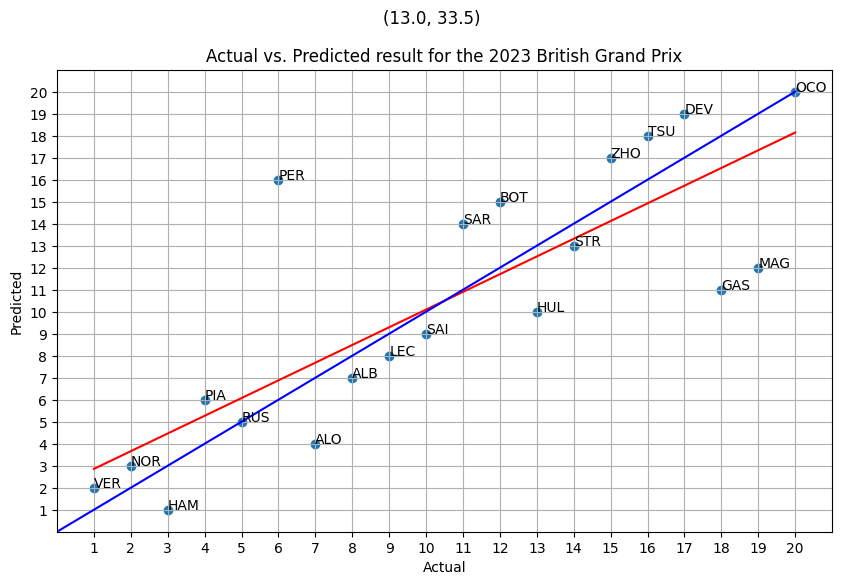

Accuracy: 0.10
     Driver  Actual  Predicted
9778    HAM       4          1
9776    NOR       2          2
9775    VER       1          3
9779    PIA       5          4
9783    ALO       9          5
9781    LEC       7          6
9786    BOT      12          7
9777    PER       3          8
9788    HUL      14          9
9790    ZHO      16         10
9794    GAS      20         11
9793    OCO      19         12
9791    MAG      17         13
9787    RIC      13         14
9784    STR      10         15
9780    RUS       6         16
9785    ALB      11         17
9789    TSU      15         18
9792    SAR      18         19
9782    SAI       8         20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


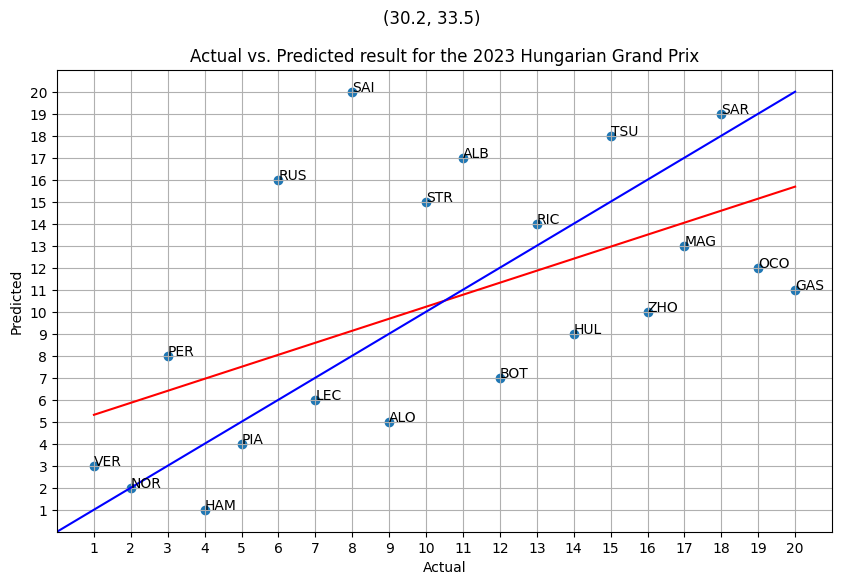

Accuracy: 0.05
     Driver  Actual  Predicted
9798    HAM       4          1
9796    PER       2          2
9795    VER       1          3
9797    LEC       3          4
9799    ALO       5          5
9800    RUS       6          6
9801    NOR       7          7
9803    STR       9          8
9813    SAI      19          9
9814    PIA      20         10
9812    HUL      18         11
9811    SAR      17         12
9810    RIC      16         13
9808    ALB      14         14
9806    BOT      12         15
9802    OCO       8         16
9807    ZHO      13         17
9809    MAG      15         18
9805    GAS      11         19
9804    TSU      10         20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


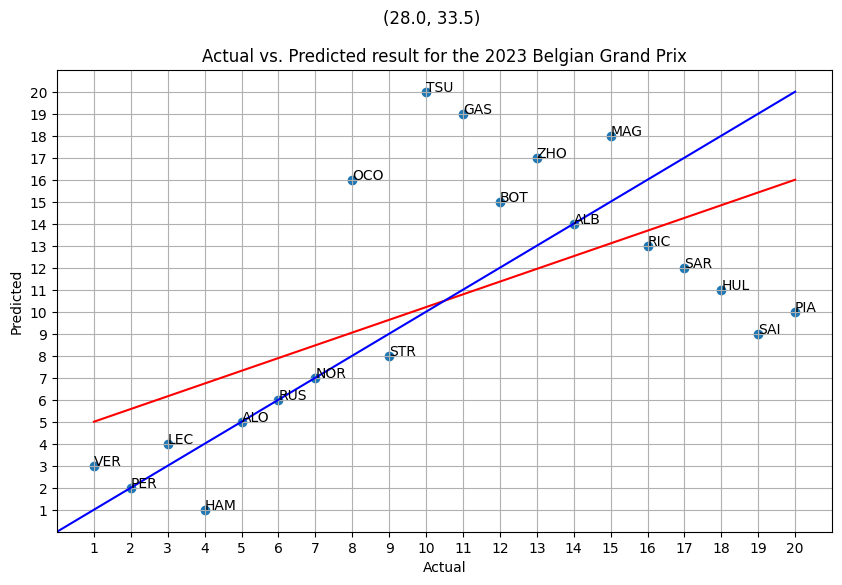

Accuracy: 0.25


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


     Driver  Actual  Predicted
9816    ALO       2          1
9820    HAM       6          2
9815    VER       1          3
9818    PER       4          4
9819    SAI       5          5
9821    NOR       7          6
9822    ALB       8          7
9823    PIA       9          8
9831    RUS      17          9
9833    LEC      19         10
9830    MAG      16         11
9828    BOT      14         12
9825    STR      11         13
9824    OCO      10         14
9817    GAS       3         15
9826    HUL      12         16
9827    LAW      13         17
9829    TSU      15         18
9832    ZHO      18         19
9834    SAR      20         20


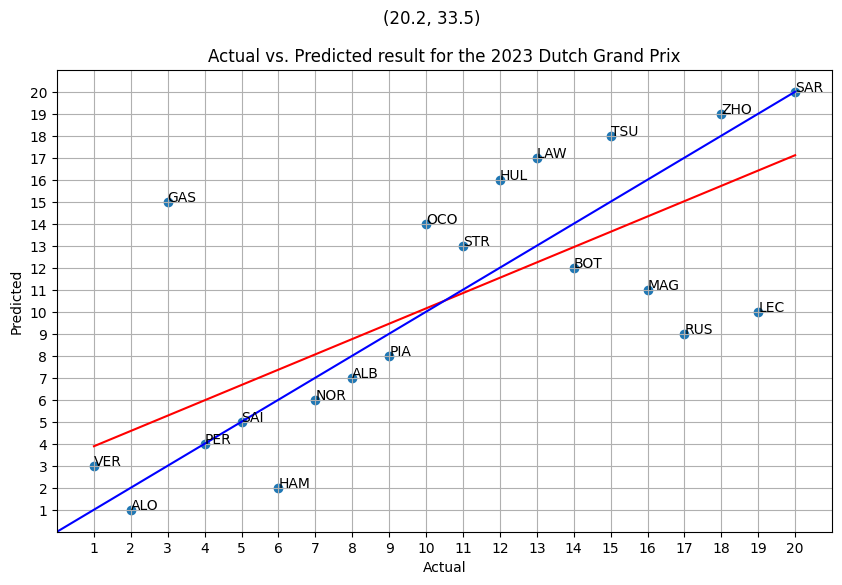

Accuracy: 0.15


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


     Driver  Actual  Predicted
9839    RUS       5          1
9837    SAI       3          2
9835    VER       1          3
9838    LEC       4          4
9840    HAM       6          5
9836    PER       2          6
9841    ALB       7          7
9842    NOR       8          8
9843    ALO       9          9
9846    PIA      12         10
9854    TSU      20         11
9852    MAG      18         12
9850    STR      16         13
9848    ZHO      14         14
9845    LAW      11         15
9844    BOT      10         16
9847    SAR      13         17
9849    GAS      15         18
9851    HUL      17         19
9853    OCO      19         20


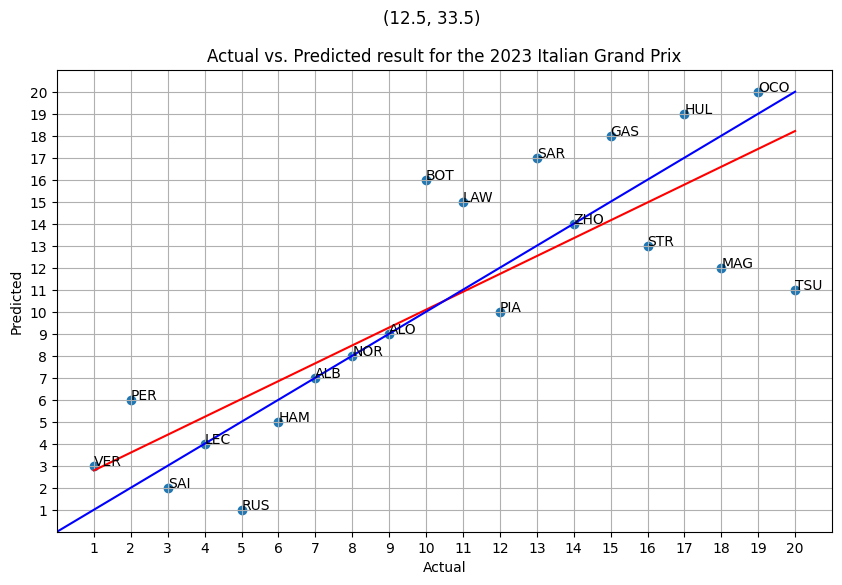

Accuracy: 0.25
     Driver  Actual  Predicted
9857    HAM       3          1
9856    NOR       2          2
9855    SAI       1          3
9858    LEC       4          4
9869    ALO      15          5
9864    MAG      10          6
9867    HUL      13          7
9863    LAW       9          8
9870    RUS      16          9
9872    OCO      18         10
9874    STR      20         11
9873    TSU      19         12
9871    BOT      17         13
9862    PER       8         14
9865    ALB      11         15
9861    PIA       7         16
9866    ZHO      12         17
9868    SAR      14         18
9860    GAS       6         19
9859    VER       5         20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


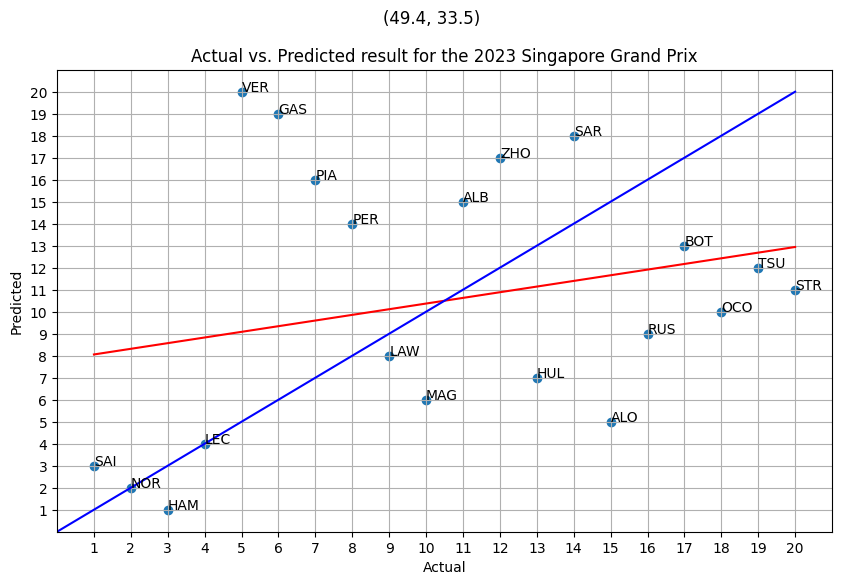

Accuracy: 0.10
     Driver  Actual  Predicted
9878    LEC       4          1
9876    NOR       2          2
9875    VER       1          3
9877    PIA       3          4
9879    HAM       5          5
9880    SAI       6          6
9881    RUS       7          7
9882    ALO       8          8
9886    TSU      12          9
9885    LAW      11         10
9893    PER      19         11
9892    STR      18         12
9889    MAG      15         13
9883    OCO       9         14
9888    HUL      14         15
9887    ZHO      13         16
9891    SAR      17         17
9890    ALB      16         18
9884    GAS      10         19
9894    BOT      20         20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


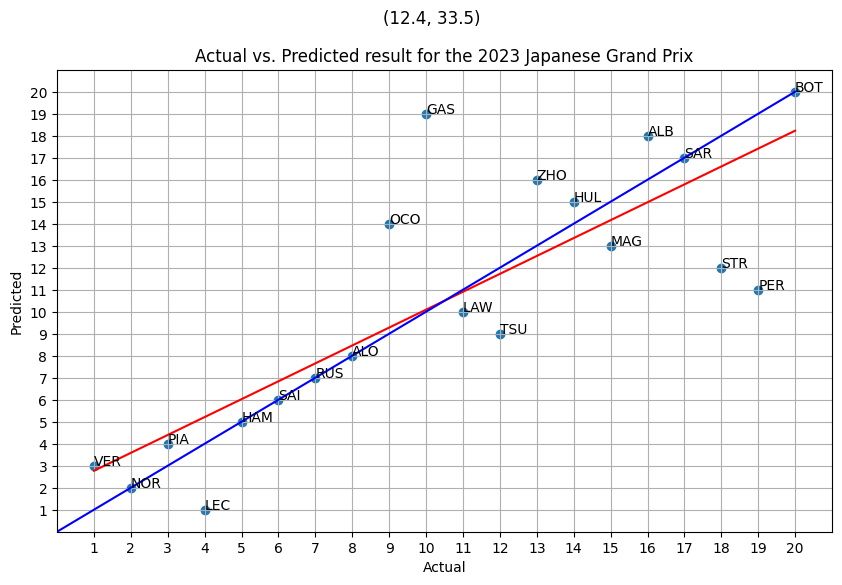

Accuracy: 0.35
     Driver  Actual  Predicted
9895    VER       1          1
9898    RUS       4          2
9896    PIA       2          3
9899    LEC       5          4
9900    ALO       6          5
9901    OCO       7          6
9897    NOR       3          7
9902    BOT       8          8
9906    GAS      12          9
9904    PER      10         10
9909    TSU      15         11
9912    SAR      18         12
9908    MAG      14         13
9905    STR      11         14
9903    ZHO       9         15
9907    ALB      13         16
9911    LAW      17         17
9910    HUL      16         18
9913    HAM      19         19
9914    SAI      20         20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


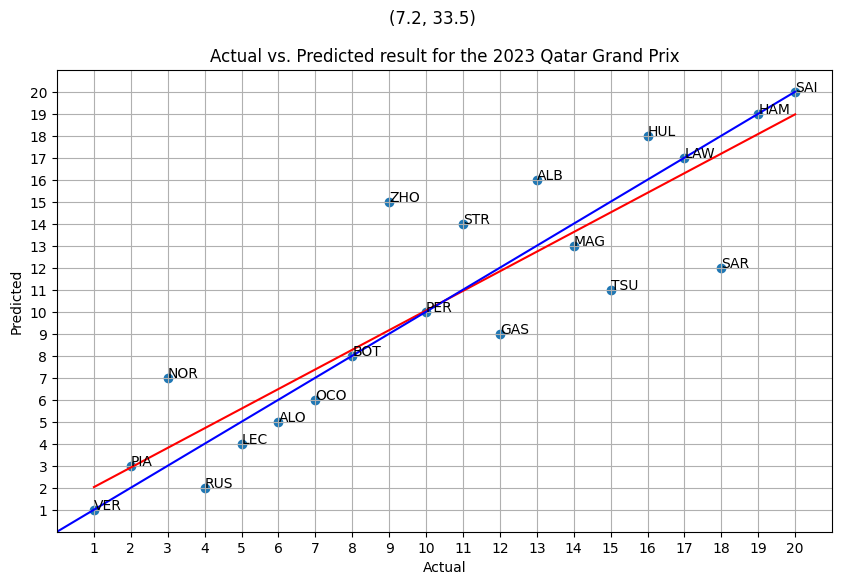

Accuracy: 0.30


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


     Driver  Actual  Predicted
9916    NOR       2          1
9917    SAI       3          2
9919    RUS       5          3
9915    VER       1          4
9918    PER       4          5
9920    GAS       6          6
9931    PIA      17          7
9922    TSU       8          8
9932    OCO      18          9
9927    ZHO      13         10
9933    HAM      19         11
9934    LEC      20         12
9930    ALO      16         13
9929    RIC      15         14
9928    MAG      14         15
9924    SAR      10         16
9923    ALB       9         17
9921    STR       7         18
9925    HUL      11         19
9926    BOT      12         20


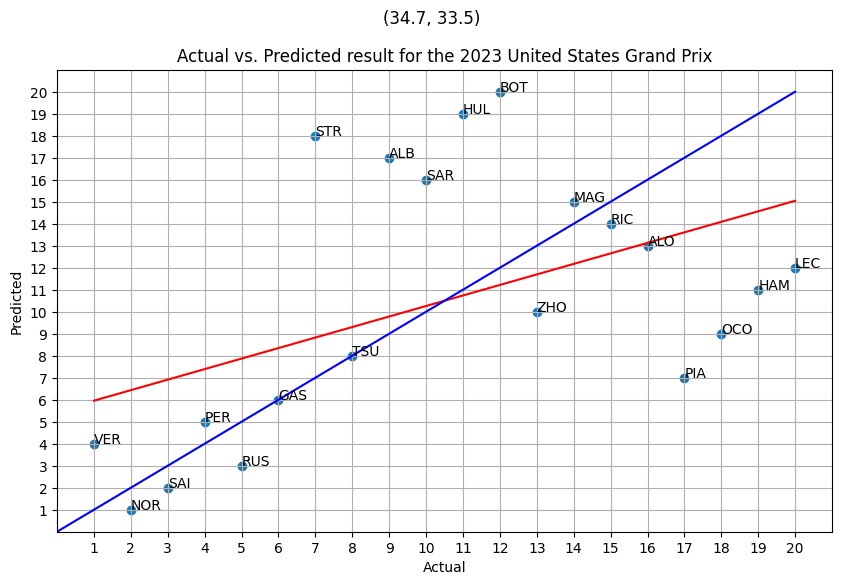

Accuracy: 0.10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


     Driver  Actual  Predicted
9936    HAM       2          1
9937    LEC       3          2
9935    VER       1          3
9938    SAI       4          4
9940    RUS       6          5
9941    RIC       7          6
9942    PIA       8          7
9949    BOT      15          8
9948    ZHO      14          9
9945    GAS      11         10
9952    ALO      18         11
9947    HUL      13         12
9951    STR      17         13
9946    TSU      12         14
9943    ALB       9         15
9939    NOR       5         16
9944    OCO      10         17
9950    SAR      16         18
9953    MAG      19         19
9954    PER      20         20


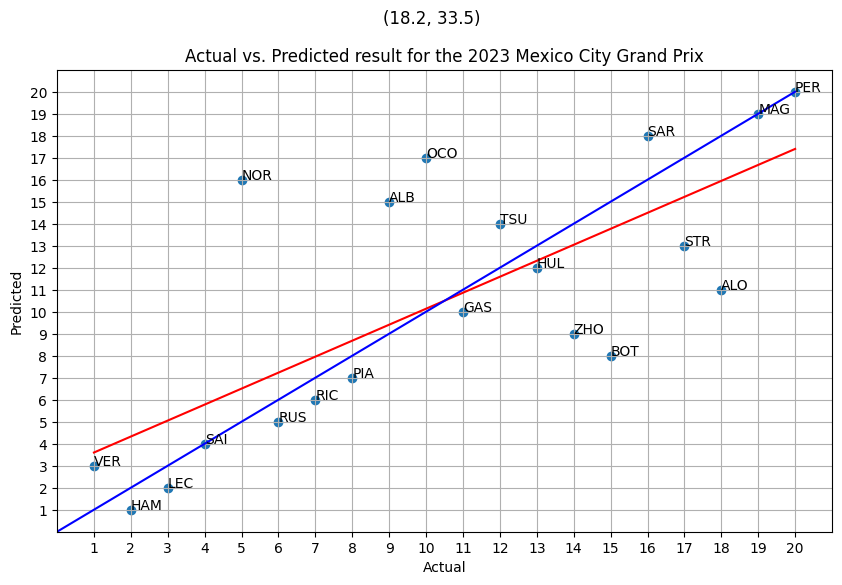

Accuracy: 0.15
     Driver  Actual  Predicted
9957    ALO       3          1
9959    STR       5          2
9955    VER       1          3
9956    NOR       2          4
9962    HAM       8          5
9960    SAI       6          6
9968    PIA      14          7
9958    PER       4          8
9966    HUL      12          9
9969    RUS      15         10
9973    ALB      19         11
9972    MAG      18         12
9970    BOT      16         13
9963    TSU       9         14
9961    GAS       7         15
9964    OCO      10         16
9965    SAR      11         17
9967    RIC      13         18
9971    ZHO      17         19
9974    LEC      20         20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


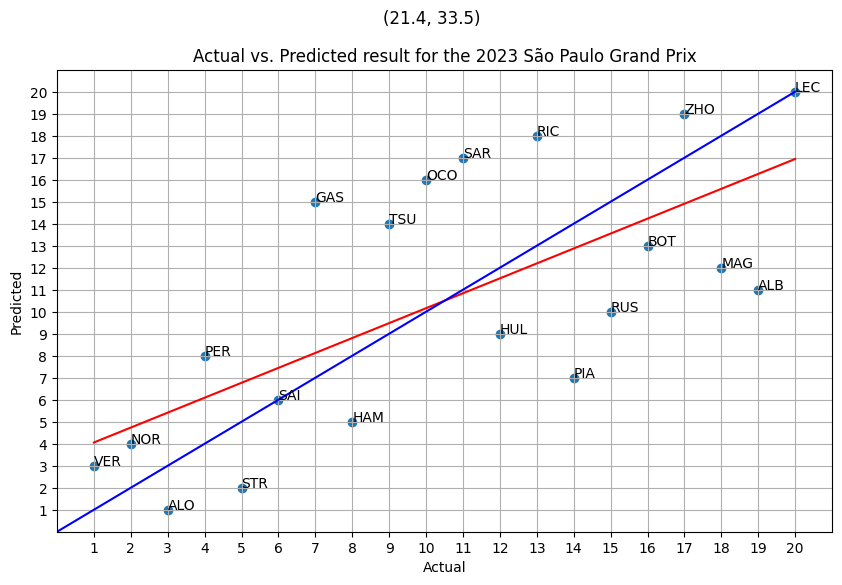

Accuracy: 0.10


In [23]:
for race_id in range(1098,1121):
    if race_id in (1103,1090) :
        continue
    X = df_new[['driverId','circuitId','year','raceId','qposition']] # can add qposition here
    df_new['position'] = df_new['position'].astype(int)
    y = df_new['position']

    X_test = X[X['raceId'] == race_id]
    y_test = y[X['raceId'] == race_id]
    X_train = X[(X['raceId'] < race_id) & (X['raceId'] > 1)]
    y_train = y[(X['raceId'] < race_id) & (X['raceId'] > 1)]

    clf = LogisticRegression(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    #print(y_pred)
    y_pred = make_predictions_unique(y_pred)
    driver_test = df_new['code'][df_new['raceId'] == race_id]
    results = pd.DataFrame({
    'Driver': driver_test,
    'Actual': y_test,
    'Predicted': y_pred
    })

    print(results.sort_values('Predicted'))
 
    mse = mean_squared_error(y_test, y_pred)

    mse10 = mean_squared_error([10]*len(y_pred), y_pred)

    m, b = np.polyfit(y_test, y_pred, 1)

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred)

    # Add labels
    for i, driver in enumerate(driver_test):
        plt.text(y_test.values[i], y_pred[i], driver)

    race_name = cursor.execute(f"select name from races where raceId = {race_id}").fetchone()[0]
    plt.plot(y_test, m*y_test + b, color='red')  # Add the line of best fit
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs. Predicted result for the 2023 {race_name}')
    plt.suptitle(f'{(mse,mse10)}')
    plt.grid(True)
    plt.xlim(0, 21)
    plt.ylim(0, 21)
    plt.xticks(range(1, 21))
    plt.yticks(range(1, 21))
    plt.plot(range(0, 21), range(0, 21), color='blue')

   
    plt.show()
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

     Driver  Actual  Predicted
9137    HAM       3          1
9136    SAI       2          2
9153    VER      19          3
9138    RUS       4          4
9140    BOT       6          5
9139    MAG       5          6
9154    GAS      20          7
9152    PER      18          8
9149    NOR      15          9
9141    OCO       7         10
9151    HUL      17         11
9148    RIC      14         12
9146    STR      12         13
9145    MSC      11         14
9150    LAT      16         15
9147    ALB      13         16
9144    ZHO      10         17
9143    ALO       9         18
9142    TSU       8         19
9135    LEC       1         20


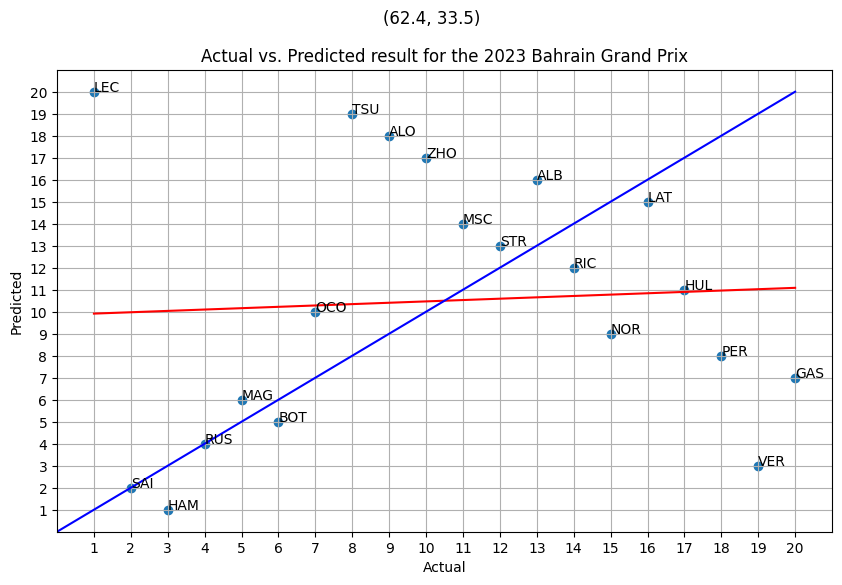

Accuracy: 0.10
     Driver  Actual  Predicted
9163    MAG       9          1
9157    SAI       3          2
9156    LEC       2          3
9158    PER       4          4
9162    GAS       8          5
9159    RUS       5          6
9155    VER       1          7
9160    OCO       6          8
9164    HAM      10          9
9161    NOR       7         10
9166    HUL      12         11
9167    STR      13         12
9168    ALB      14         13
9169    BOT      15         14
9170    ALO      16         15
9171    RIC      17         16
9165    ZHO      11         17
9172    LAT      18         18
9173    TSU      19         19
9174    MSC      20         20


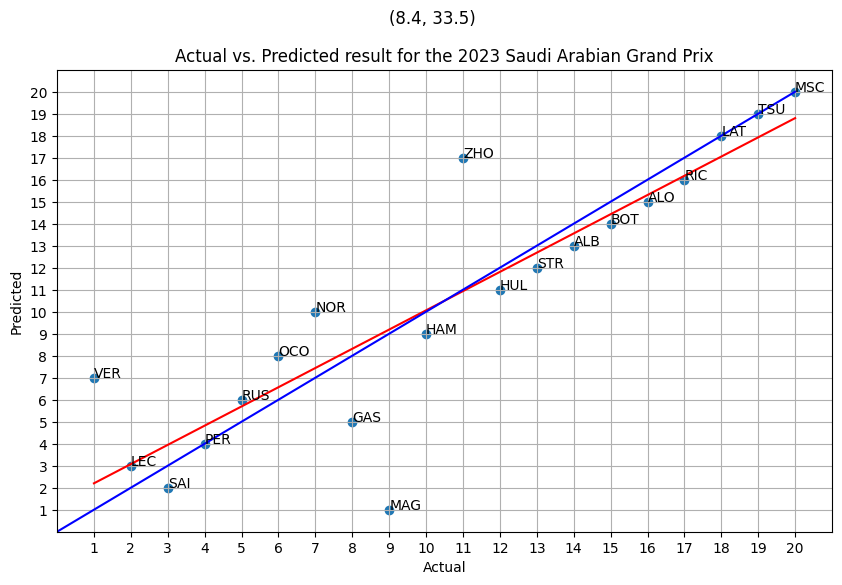

Accuracy: 0.20
     Driver  Actual  Predicted
9175    LEC       1          1
9178    HAM       4          2
9176    PER       2          3
9177    RUS       3          4
9180    RIC       6          5
9179    NOR       5          6
9183    GAS       9          7
9184    ALB      10          8
9181    OCO       7          9
9185    ZHO      11         10
9186    STR      12         11
9182    BOT       8         12
9187    MSC      13         13
9191    ALO      17         14
9189    TSU      15         15
9190    LAT      16         16
9188    MAG      14         17
9193    VET      19         18
9192    VER      18         19
9194    SAI      20         20


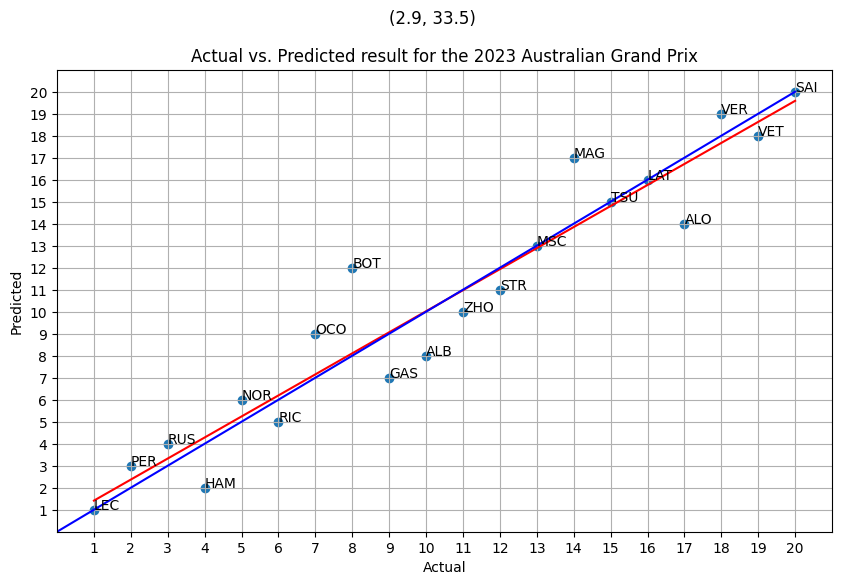

Accuracy: 0.25
     Driver  Actual  Predicted
9195    VER       1          1
9200    LEC       6          2
9203    MAG       9          3
9212    RIC      18          4
9211    MSC      17          5
9196    PER       2          6
9197    NOR       3          7
9198    RUS       4          8
9209    ZHO      15          9
9207    HAM      13         10
9208    OCO      14         11
9206    GAS      12         12
9204    STR      10         13
9205    ALB      11         14
9199    BOT       5         15
9201    TSU       7         16
9202    VET       8         17
9210    LAT      16         18
9213    ALO      19         19
9214    SAI      20         20


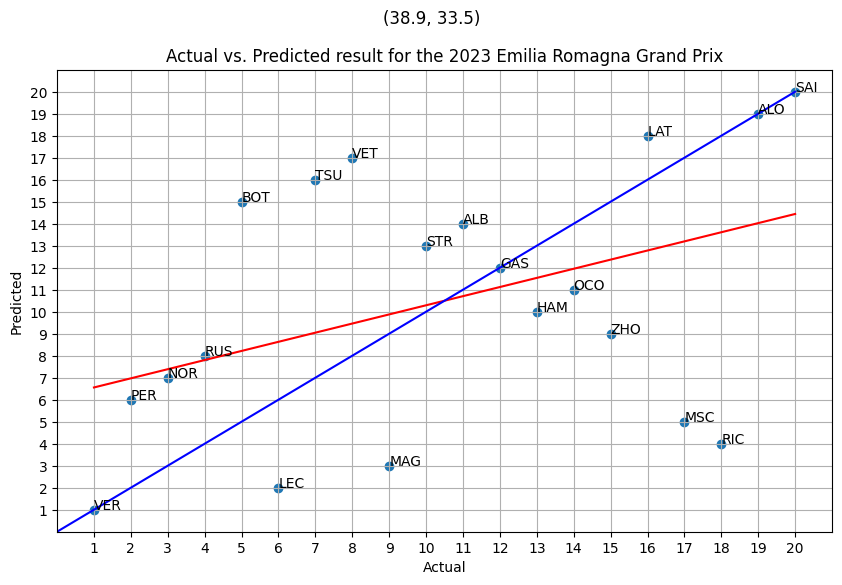

Accuracy: 0.20
     Driver  Actual  Predicted
9217    SAI       3          1
9215    VER       1          2
9218    PER       4          3
9216    LEC       2          4
9220    HAM       6          5
9221    BOT       7          6
9226    TSU      12          7
9225    ALO      11          8
9224    STR      10          9
9232    GAS      18         10
9230    MAG      16         11
9227    RIC      13         12
9223    ALB       9         13
9222    OCO       8         14
9231    VET      17         15
9233    NOR      19         16
9219    RUS       5         17
9228    LAT      14         18
9234    ZHO      20         19
9229    MSC      15         20


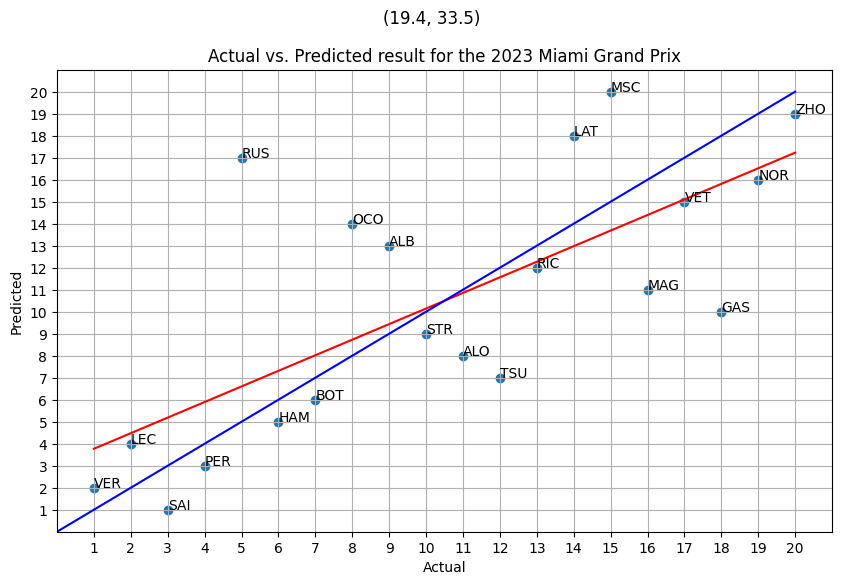

Accuracy: 0.00
     Driver  Actual  Predicted
9254    LEC      20          1
9238    SAI       4          2
9242    NOR       8          3
9240    BOT       6          4
9237    RUS       3          5
9239    HAM       5          6
9251    MAG      17          7
9253    ZHO      19          8
9252    ALB      18          9
9241    OCO       7         10
9248    MSC      14         11
9247    GAS      13         12
9243    ALO       9         13
9249    STR      15         14
9244    TSU      10         15
9250    LAT      16         16
9245    VET      11         17
9236    PER       2         18
9235    VER       1         19
9246    RIC      12         20


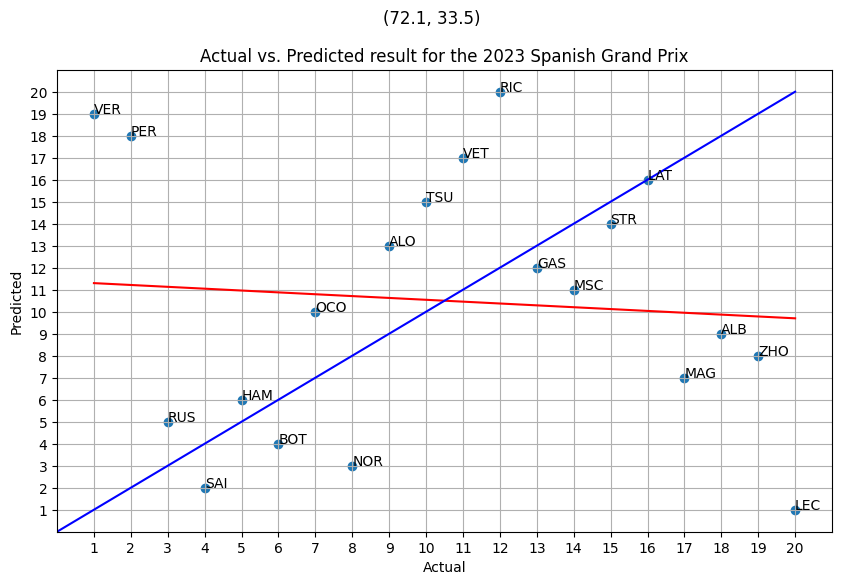

Accuracy: 0.05
     Driver  Actual  Predicted
9256    SAI       2          1
9255    PER       1          2
9257    VER       3          3
9259    RUS       5          4
9260    NOR       6          5
9262    HAM       8          6
9263    BOT       9          7
9266    OCO      12          8
9272    ALB      18          9
9271    TSU      17         10
9265    GAS      11         11
9264    VET      10         12
9267    RIC      13         13
9270    ZHO      16         14
9268    STR      14         15
9261    ALO       7         16
9269    LAT      15         17
9274    MAG      20         18
9273    MSC      19         19
9258    LEC       4         20


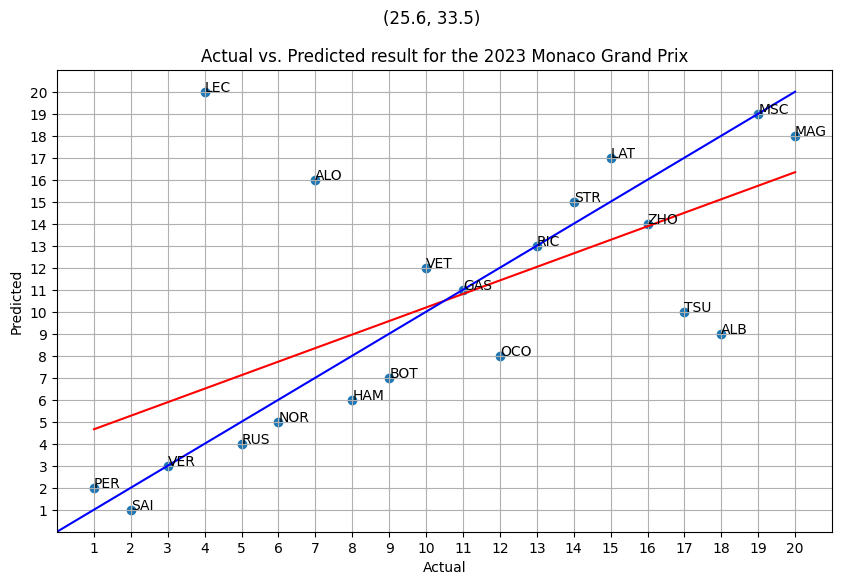

Accuracy: 0.20
     Driver  Actual  Predicted
9275    VER       1          1
9294    SAI      20          2
9276    PER       2          3
9293    LEC      19          4
9278    HAM       4          5
9277    RUS       3          6
9279    GAS       5          7
9280    VET       6          8
9283    NOR       9          9
9287    TSU      13         10
9281    ALO       7         11
9285    BOT      11         12
9284    OCO      10         13
9286    ALB      12         14
9290    STR      16         15
9289    LAT      15         16
9282    RIC       8         17
9291    MAG      17         18
9288    MSC      14         19
9292    ZHO      18         20


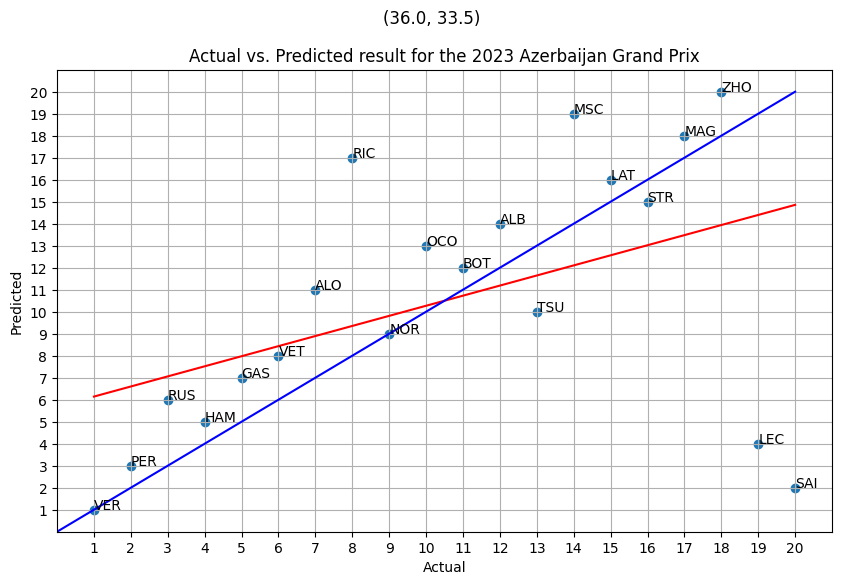

Accuracy: 0.10
     Driver  Actual  Predicted
9295    VER       1          1
9303    ALO       9          2
9297    HAM       3          3
9296    SAI       2          4
9298    RUS       4          5
9300    OCO       6          6
9311    MAG      17          7
9307    ALB      13          8
9301    BOT       7          9
9308    GAS      14         10
9306    VET      12         11
9305    RIC      11         12
9299    LEC       5         13
9302    ZHO       8         14
9304    STR      10         15
9309    NOR      15         16
9310    LAT      16         17
9312    TSU      18         18
9313    MSC      19         19
9314    PER      20         20


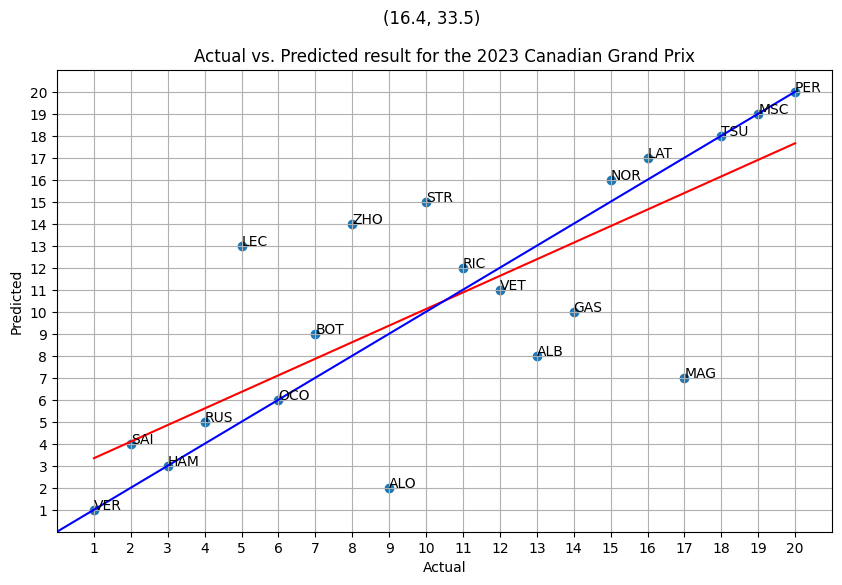

Accuracy: 0.30
     Driver  Actual  Predicted
9315    SAI       1          1
9317    HAM       3          2
9316    PER       2          3
9318    LEC       4          4
9320    NOR       6          5
9321    VER       7          6
9319    ALO       5          7
9326    LAT      12          8
9328    TSU      14          9
9325    STR      11         10
9329    OCO      15         11
9323    VET       9         12
9327    RIC      13         13
9324    MAG      10         14
9330    GAS      16         15
9331    BOT      17         16
9332    RUS      18         17
9322    MSC       8         18
9333    ZHO      19         19
9334    ALB      20         20


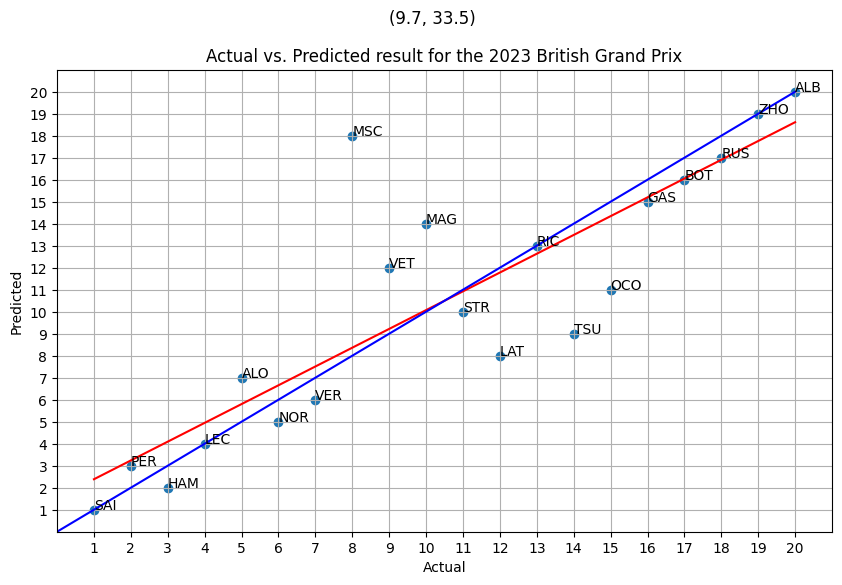

Accuracy: 0.25
     Driver  Actual  Predicted
9336    VER       2          1
9338    RUS       4          2
9335    LEC       1          3
9337    HAM       3          4
9342    MAG       8          5
9339    OCO       5          6
9344    ALO      10          7
9348    ZHO      14          8
9346    ALB      12          9
9351    VET      17         10
9352    SAI      18         11
9347    STR      13         12
9343    RIC       9         13
9353    LAT      19         14
9341    NOR       7         15
9349    GAS      15         16
9345    BOT      11         17
9350    TSU      16         18
9340    MSC       6         19
9354    PER      20         20


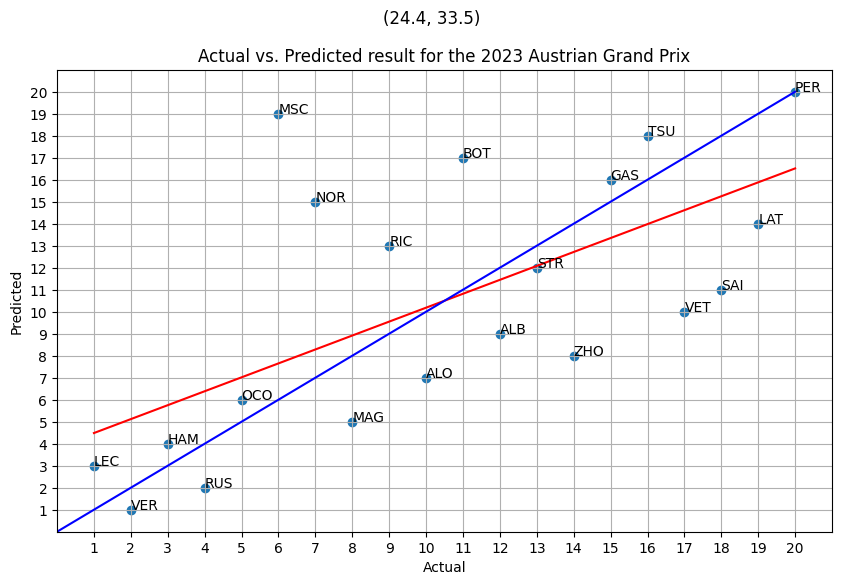

Accuracy: 0.05
     Driver  Actual  Predicted
9358    PER       4          1
9373    LEC      19          2
9356    HAM       2          3
9360    ALO       6          4
9357    RUS       3          5
9361    NOR       7          6
9355    VER       1          7
9367    ALB      13          8
9369    MSC      15          9
9363    RIC       9         10
9362    OCO       8         11
9365    VET      11         12
9364    STR      10         13
9366    GAS      12         14
9370    ZHO      16         15
9372    MAG      18         16
9374    TSU      20         17
9371    LAT      17         18
9368    BOT      14         19
9359    SAI       5         20


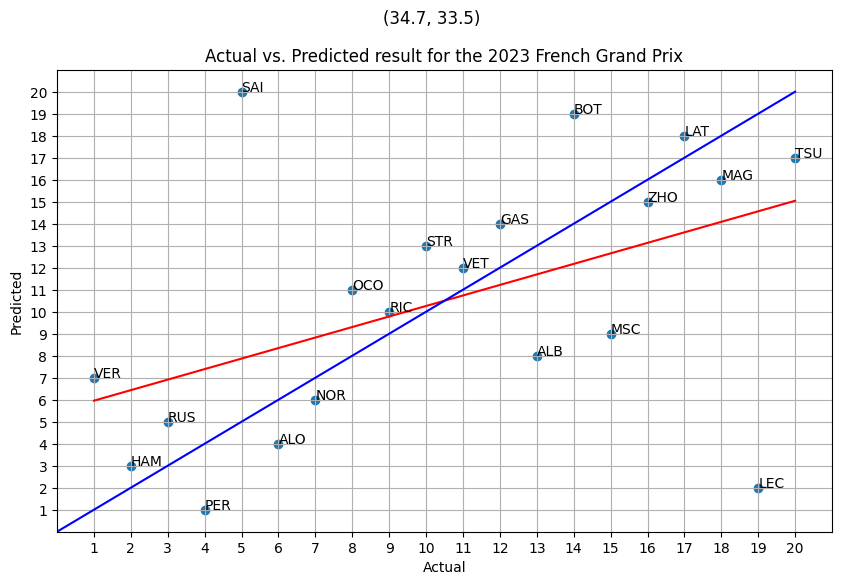

Accuracy: 0.00
     Driver  Actual  Predicted
9378    SAI       4          1
9394    BOT      20          2
9376    HAM       2          3
9380    LEC       6          4
9381    NOR       7          5
9382    ALO       8          6
9383    OCO       9          7
9384    VET      10          8
9379    PER       5          9
9387    ZHO      13         10
9386    GAS      12         11
9389    RIC      15         12
9385    STR      11         13
9393    TSU      19         14
9392    LAT      18         15
9391    ALB      17         16
9390    MAG      16         17
9375    VER       1         18
9377    RUS       3         19
9388    MSC      14         20


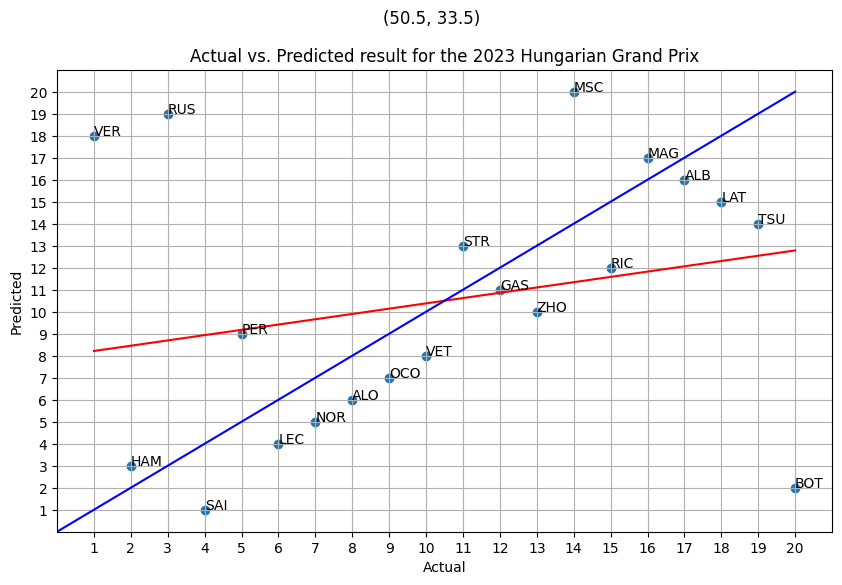

Accuracy: 0.00
     Driver  Actual  Predicted
9395    VER       1          1
9406    NOR      12          2
9397    SAI       3          3
9396    PER       2          4
9409    RIC      15          5
9410    MAG      16          6
9400    LEC       6          7
9399    ALO       5          8
9401    OCO       7          9
9405    STR      11         10
9402    VET       8         11
9404    ALB      10         12
9403    GAS       9         13
9408    ZHO      14         14
9411    MSC      17         15
9412    LAT      18         16
9407    TSU      13         17
9398    RUS       4         18
9413    BOT      19         19
9414    HAM      20         20


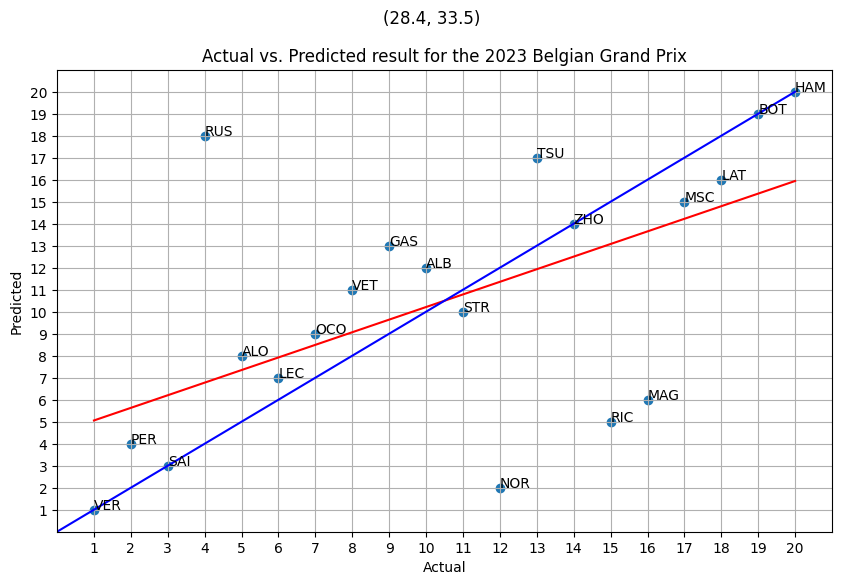

Accuracy: 0.25
     Driver  Actual  Predicted
9415    VER       1          1
9417    LEC       3          2
9416    RUS       2          3
9418    HAM       4          4
9419    PER       5          5
9421    NOR       7          6
9423    OCO       9          7
9420    ALO       6          8
9425    GAS      11          9
9428    VET      14         10
9431    RIC      17         11
9424    STR      10         12
9426    ALB      12         13
9430    ZHO      16         14
9433    BOT      19         15
9429    MAG      15         16
9432    LAT      18         17
9422    SAI       8         18
9434    TSU      20         19
9427    MSC      13         20


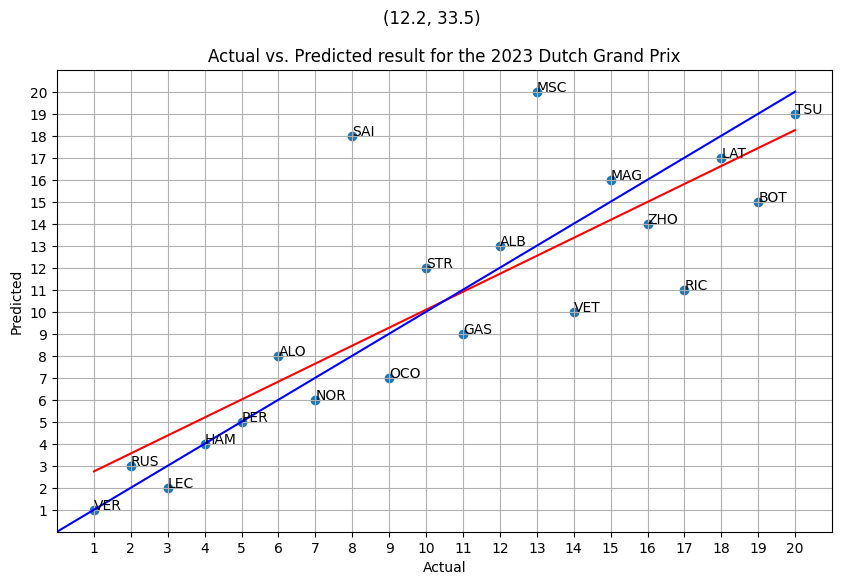

Accuracy: 0.15
     Driver  Actual  Predicted
9437    RUS       3          1
9436    LEC       2          2
9435    VER       1          3
9439    HAM       5          4
9440    PER       6          5
9453    ALO      19          6
9441    NOR       7          7
9438    SAI       4          8
9445    OCO      11          9
9442    GAS       8         10
9447    BOT      13         11
9452    STR      18         12
9444    ZHO      10         13
9443    DEV       9         14
9451    RIC      17         15
9450    MAG      16         16
9448    TSU      14         17
9446    MSC      12         18
9449    LAT      15         19
9454    VET      20         20


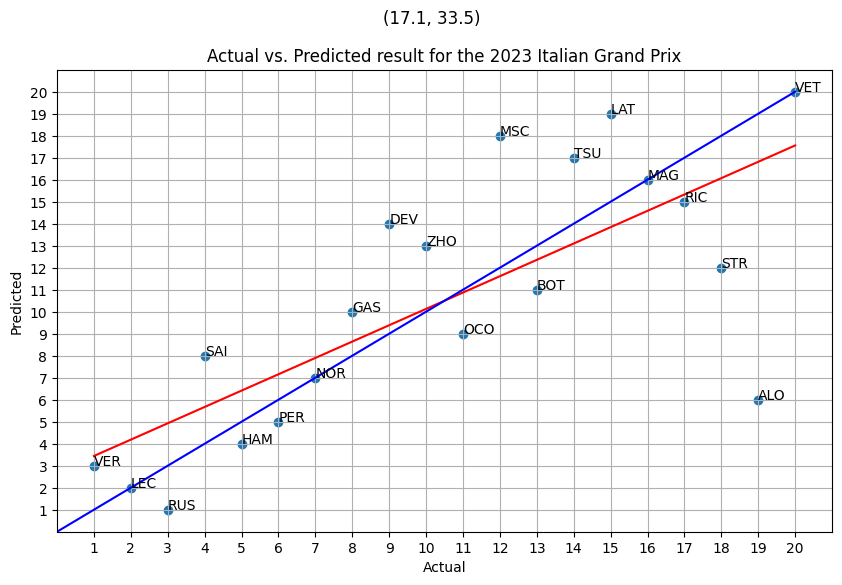

Accuracy: 0.20


ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by RandomForestClassifier.

In [22]:
for race_id in range(1074,1121):
    if race_id == 1103:
        continue
    X = df_new[['driverId','circuitId','year','raceId','qposition']] # can add qposition here
    df_new['position'] = df_new['position'].astype(int)
    y = df_new['position']

    X_test = X[X['raceId'] == race_id]
    y_test = y[X['raceId'] == race_id]
    X_train = X[(X['raceId'] < race_id) & (X['raceId'] > 1)]
    y_train = y[(X['raceId'] < race_id) & (X['raceId'] > 1)]

    clf = RandomForestClassifier(n_estimators=500, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    y_pred = make_predictions_unique(y_pred)
    driver_test = df_new['code'][df_new['raceId'] == race_id]
    results = pd.DataFrame({
    'Driver': driver_test,
    'Actual': y_test,
    'Predicted': y_pred
    })

    print(results.sort_values('Predicted'))
 
    mse = mean_squared_error(y_test, y_pred)

    mse10 = mean_squared_error([10]*len(y_pred), y_pred)

    m, b = np.polyfit(y_test, y_pred, 1)

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred)

    # Add labels
    for i, driver in enumerate(driver_test):
        plt.text(y_test.values[i], y_pred[i], driver)

    race_name = cursor.execute(f"select name from races where raceId = {race_id}").fetchone()[0]
    plt.plot(y_test, m*y_test + b, color='red')  # Add the line of best fit
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs. Predicted result for the 2023 {race_name}')
    plt.suptitle(f'{(mse,mse10)}')
    plt.grid(True)
    plt.xlim(0, 21)
    plt.ylim(0, 21)
    plt.xticks(range(1, 21))
    plt.yticks(range(1, 21))
    plt.plot(range(0, 21), range(0, 21), color='blue')

   
    plt.show()
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

models = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), SVC(), GaussianNB(), KNeighborsClassifier()]
names = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'SVC', 'GaussianNB', 'KNeighborsClassifier']
model_dict = dict(zip(models, names))

mean_results = []
mse_results = []
results = []
name = []

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

for model in models:
    cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    result = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    mean_results.append(result.mean())
    results.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} Accuracy: {result.mean()}')

    # Fit the model on the training data and make predictions on the test data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate the MSE and add it to the list of MSE results
    mse = mean_squared_error(y_test, y_pred)
    mse_results.append(mse)
    print(f'{model_dict[model]} MSE: {mse}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIM

LogisticRegression Accuracy: 0.09423427705653427


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


LogisticRegression MSE: 43.555338859093126
DecisionTreeClassifier Accuracy: 0.08545378925165623
DecisionTreeClassifier MSE: 49.533398342272065


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# use the request library to make a get request to the url below
url = 'https://www.formula1.com/en/results/2024/races/1250/las-vegas/race'
import requests
response = requests.get(url)
data = response.json()
data

JSONDecodeError: Expecting value: line 1 column 1 (char 0)